# 2D Fields

This notebook converts Xylar's `plotComparisonFrames.py` to jupyter notebook style.

Sorry for the clunkiness!

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

Models: 
```
COCO   MITgcm-BAS          MITgcm-JPL  MOM6_SIGMA_ZSTAR  NEMO-CNRS      POP2x
FVCOM  MITgcm_BAS_Coupled  MOM6        MPAS-Ocean        NEMO-UKESM1is  ROMS-UTAS
```

In [2]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)


# 2D Fields

temperatureXZ


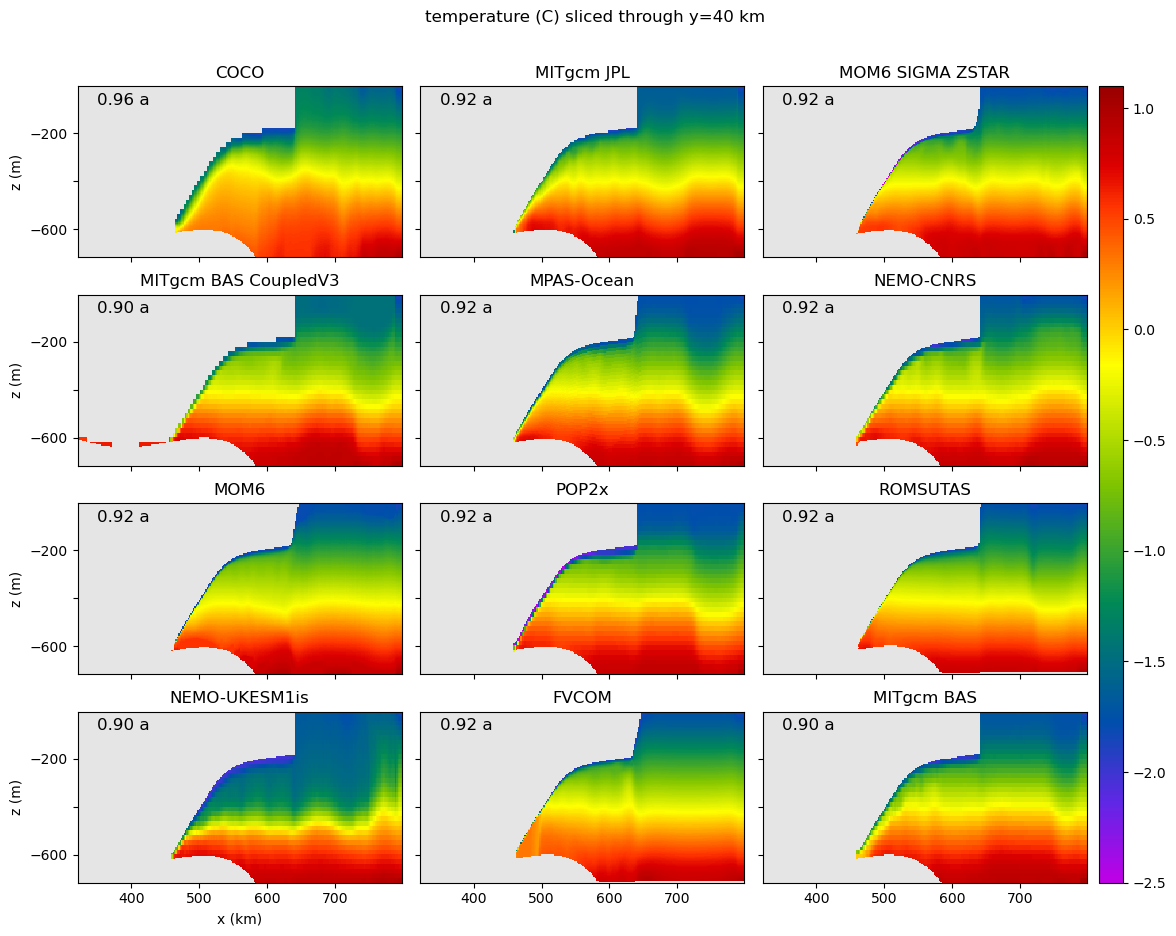

meltRate


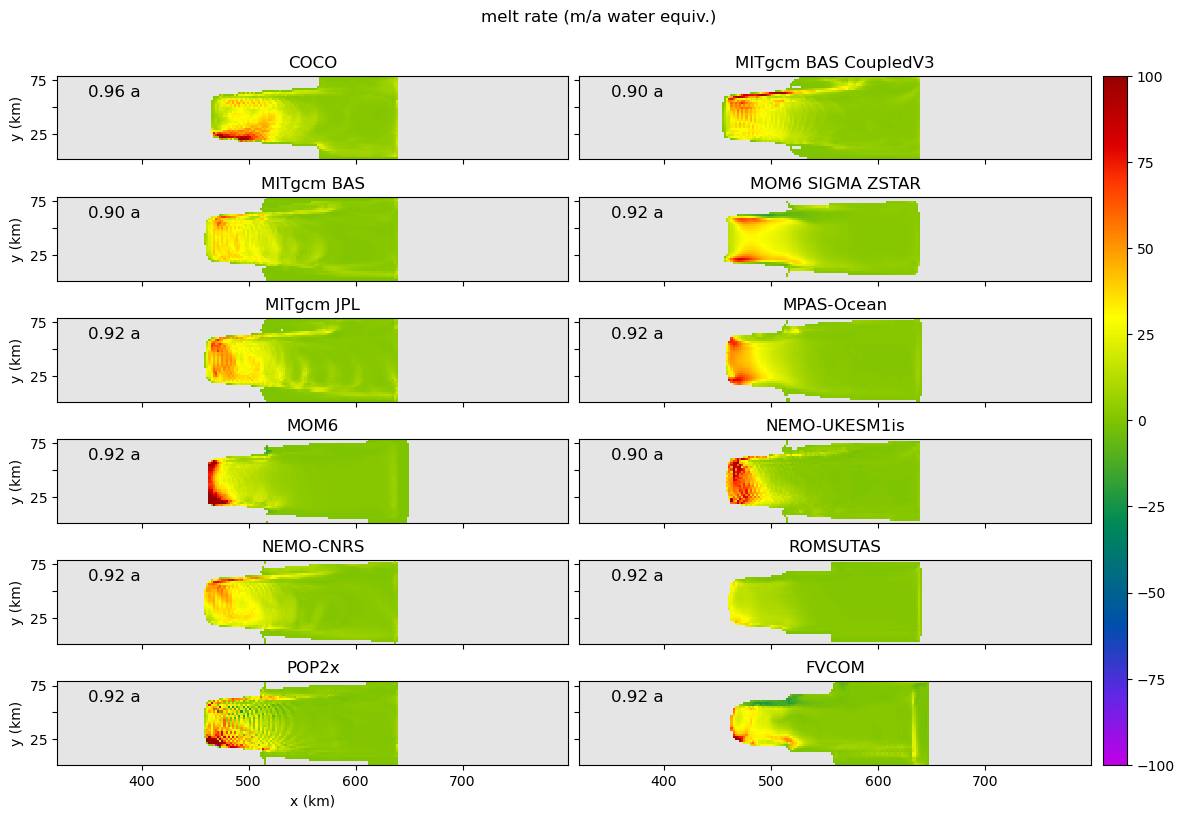

thermalDriving


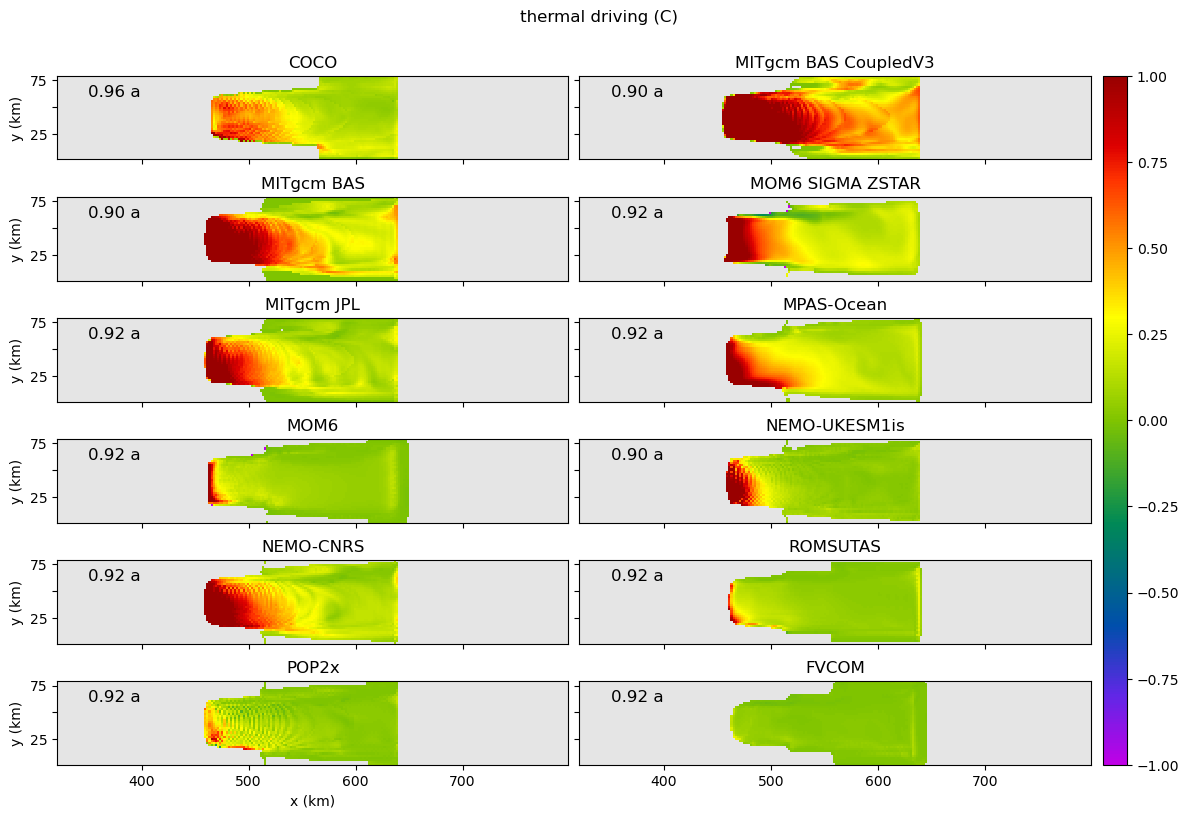

frictionVelocity


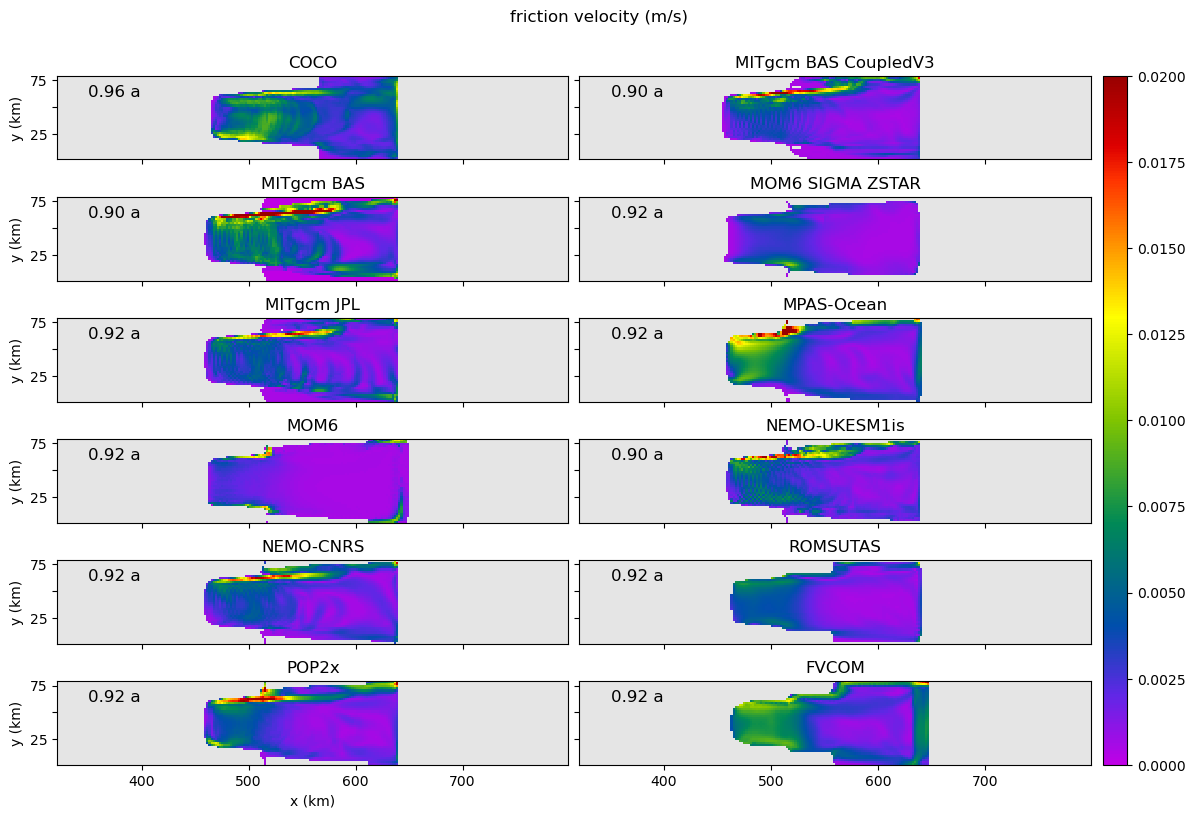

barotropicStreamfunction


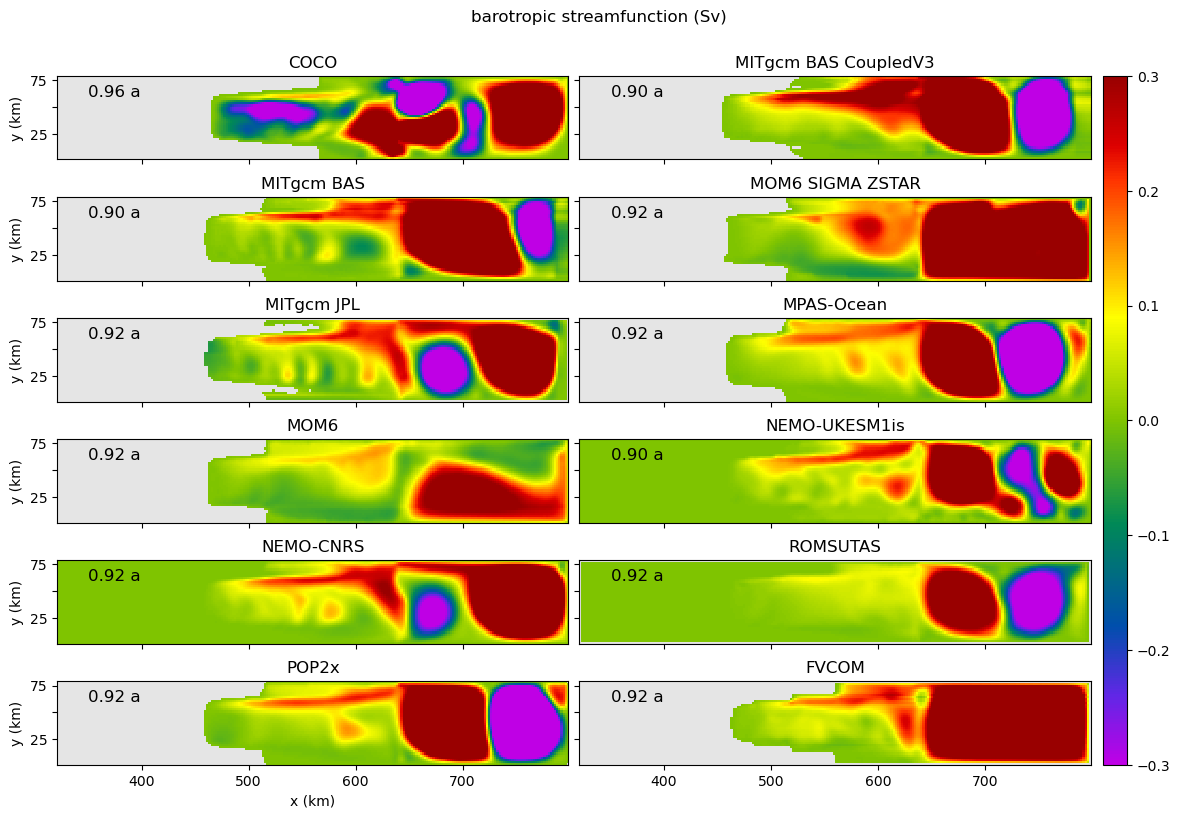

bottomSalinity


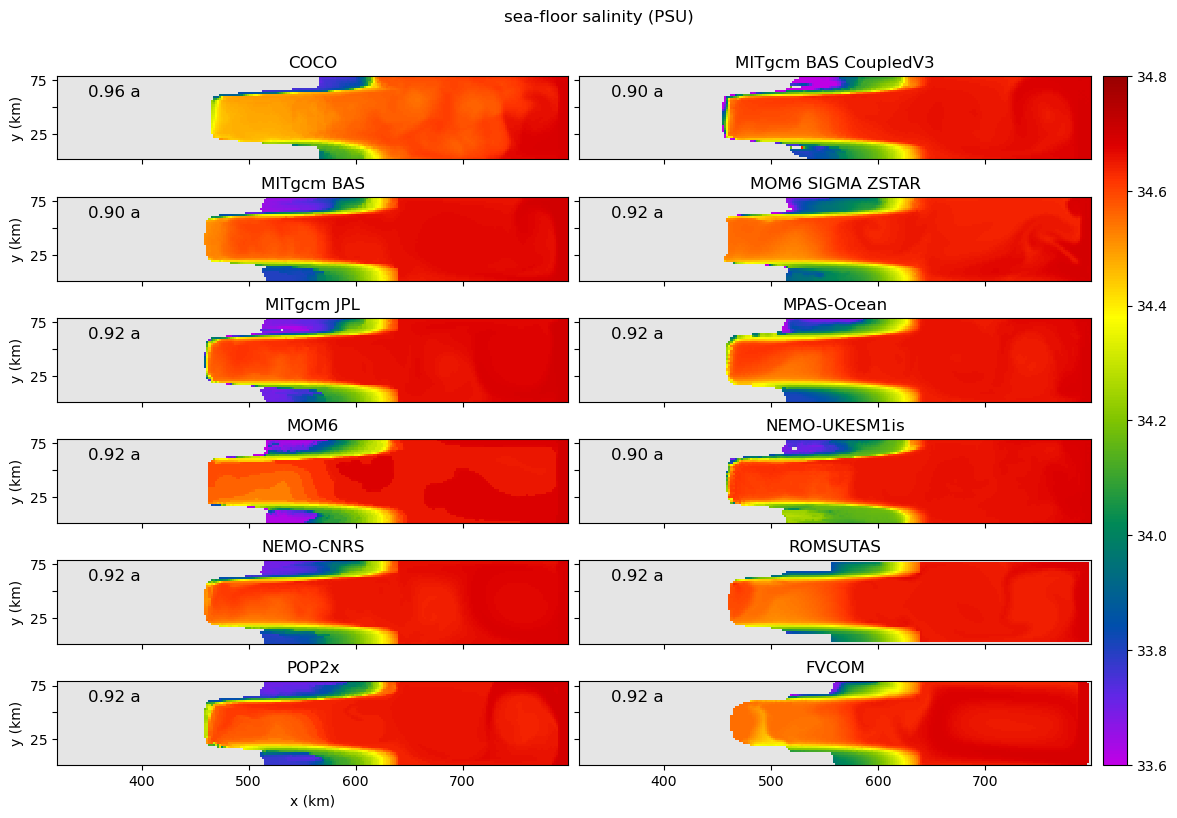

bottomTemperature


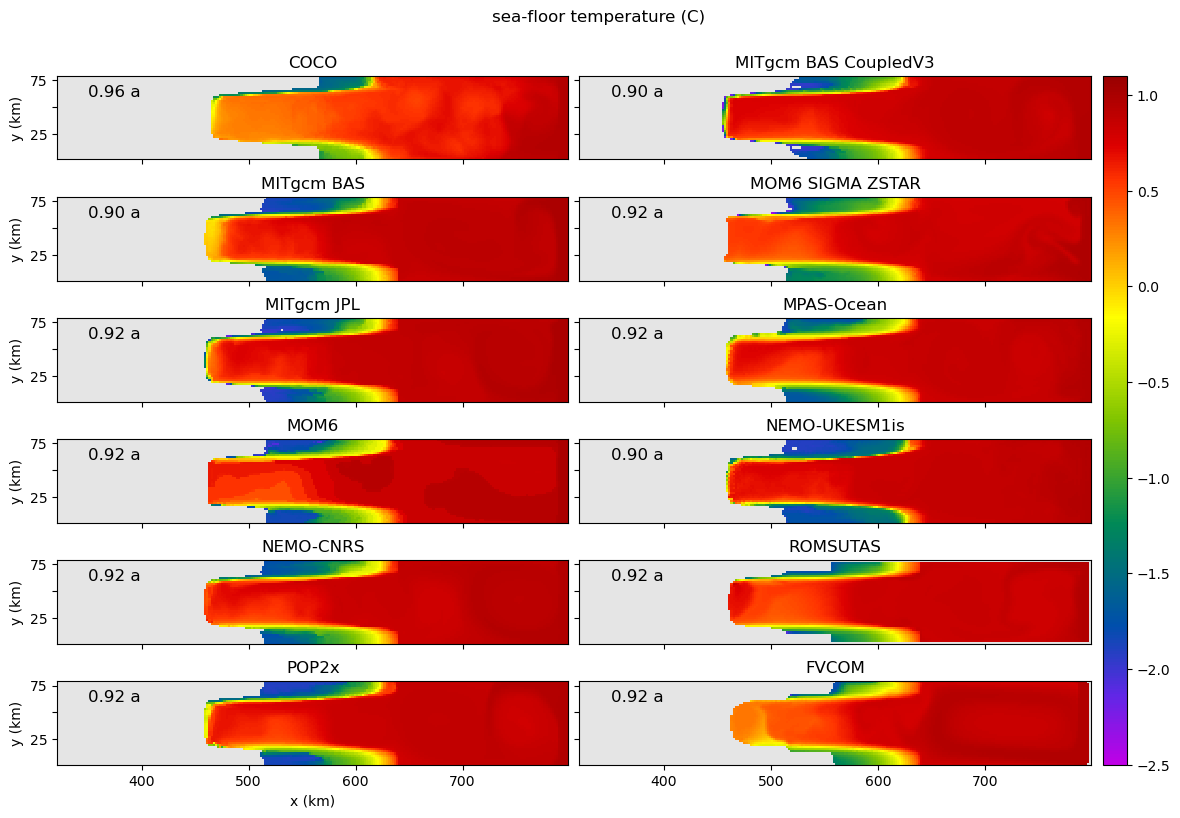

halineDriving


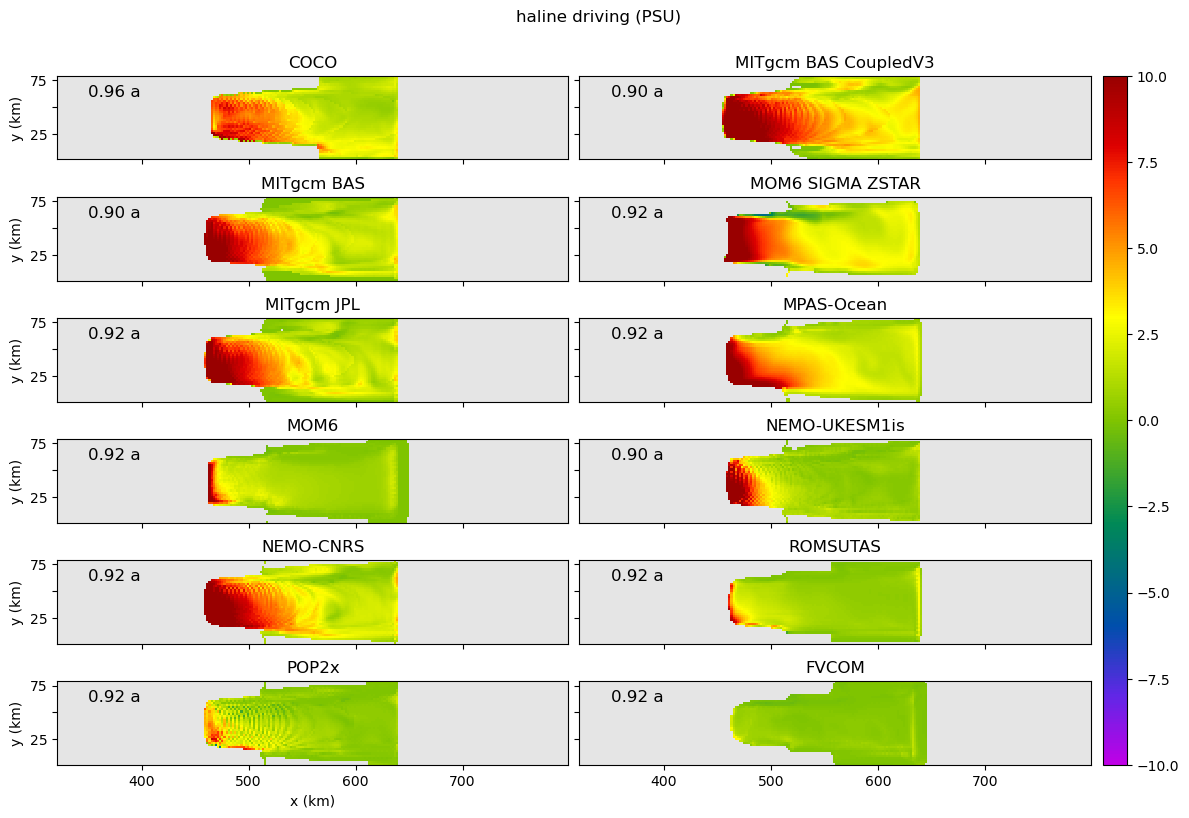

overturningStreamfunction


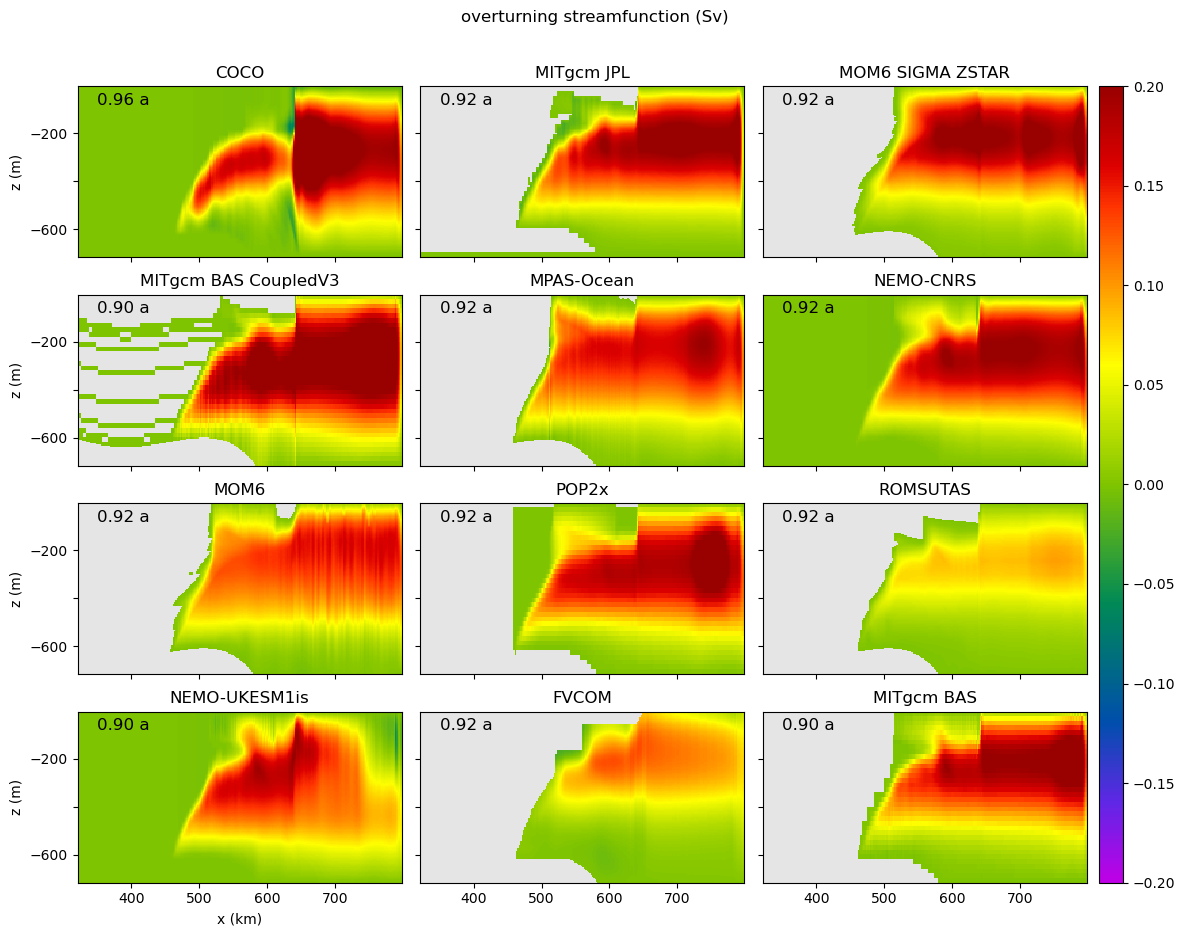

salinityXZ


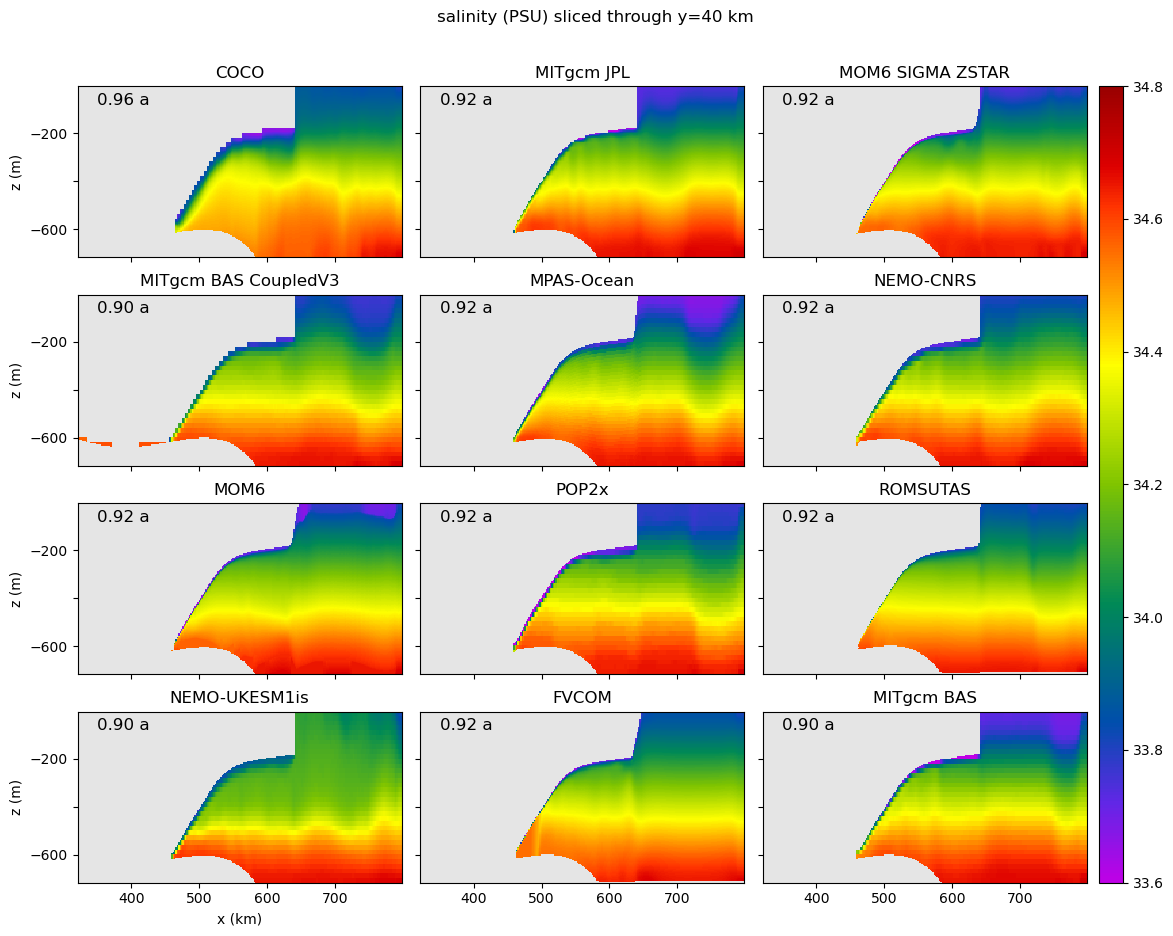

salinityYZ


/jobfs/117173370.gadi-pbs/ipykernel_1700573/3641189161.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


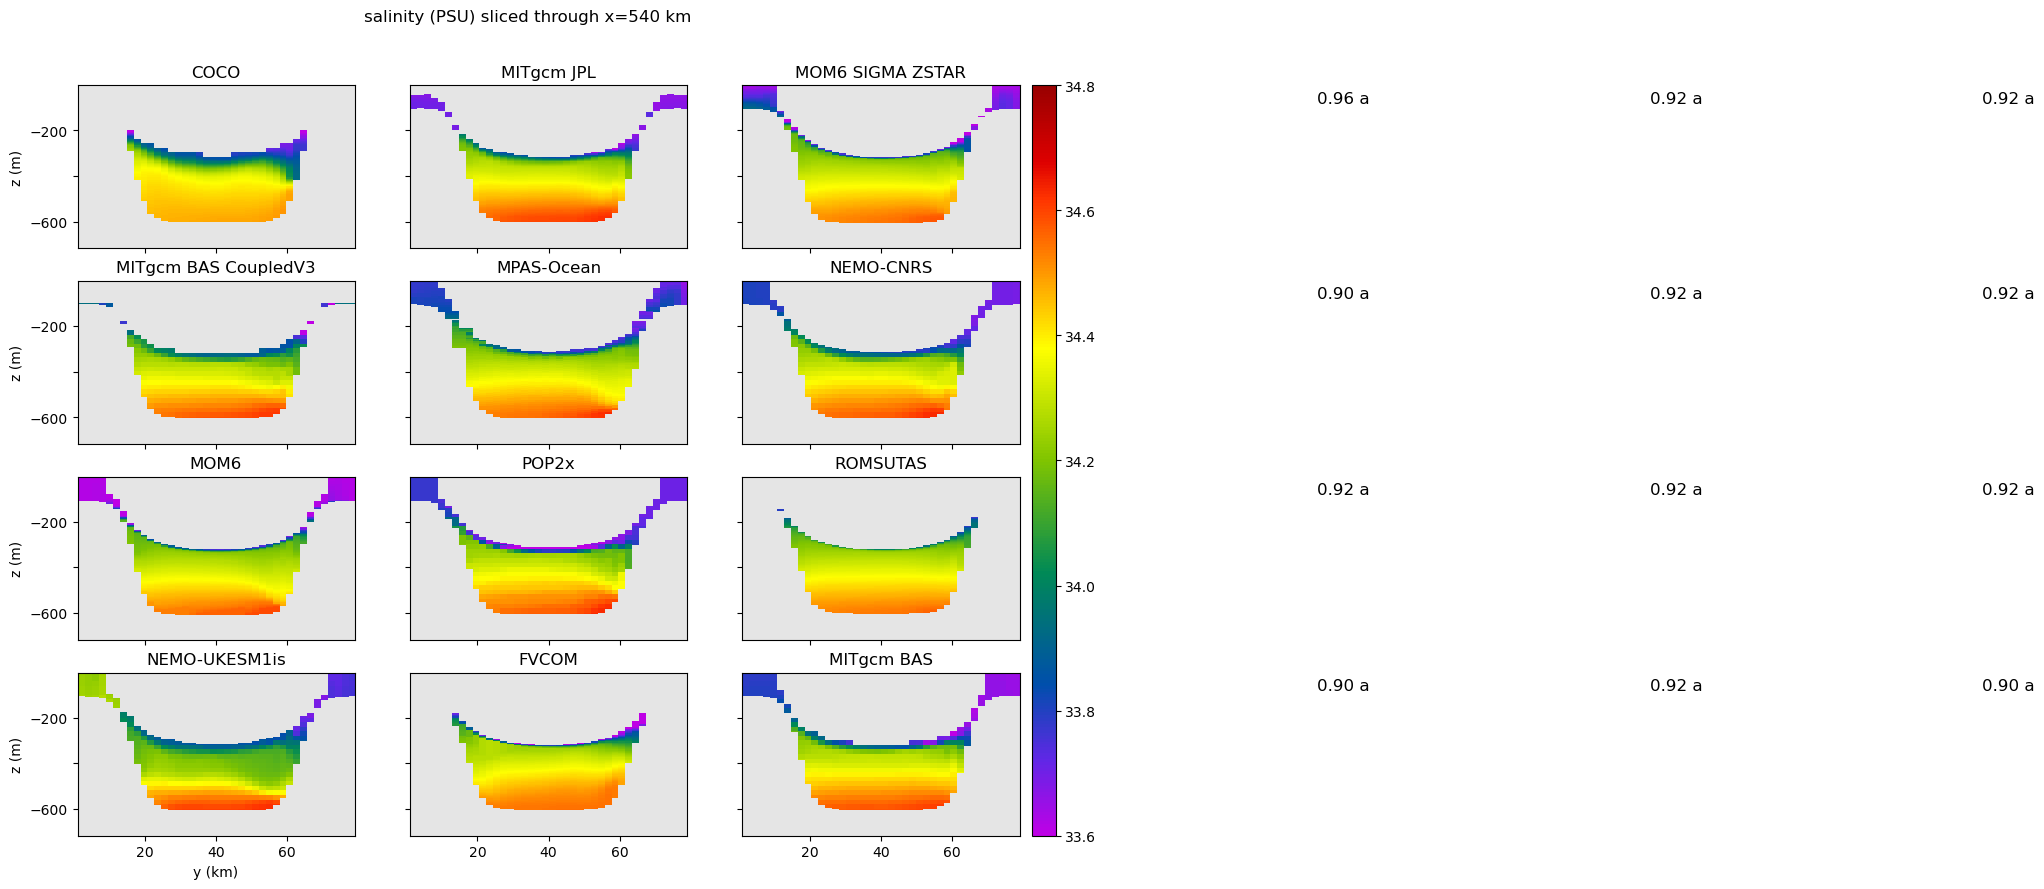

temperatureYZ


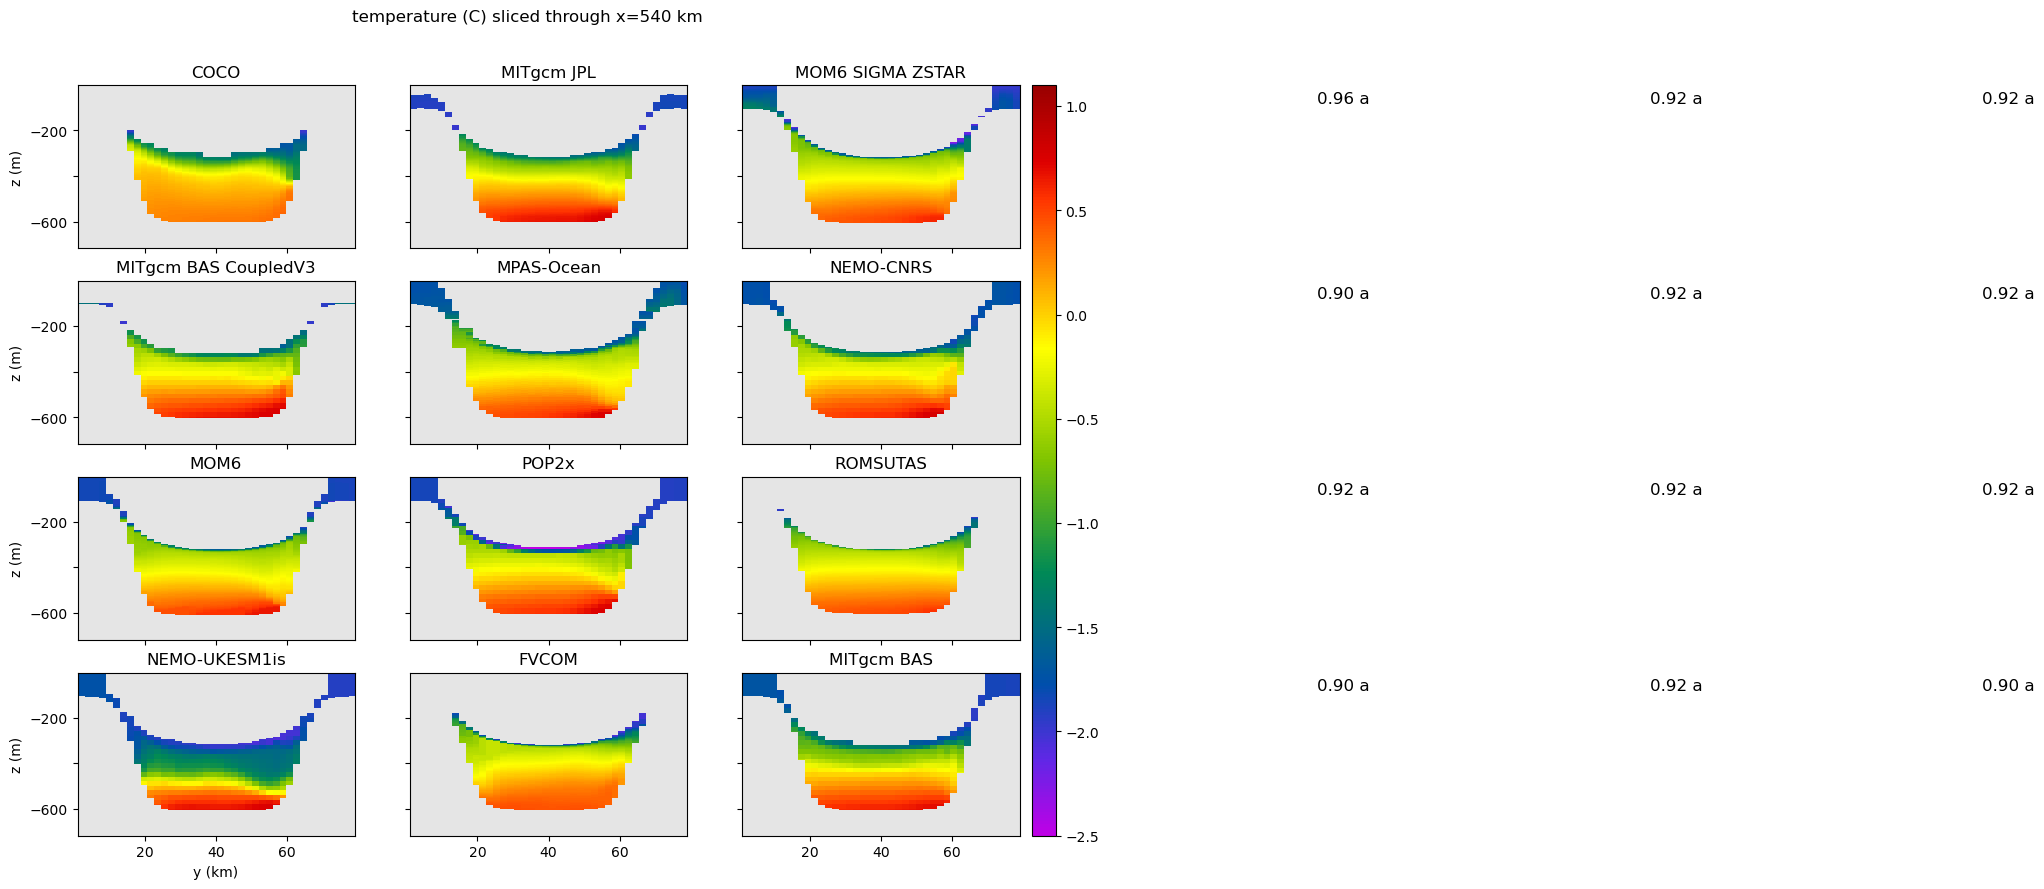

uBoundaryLayer


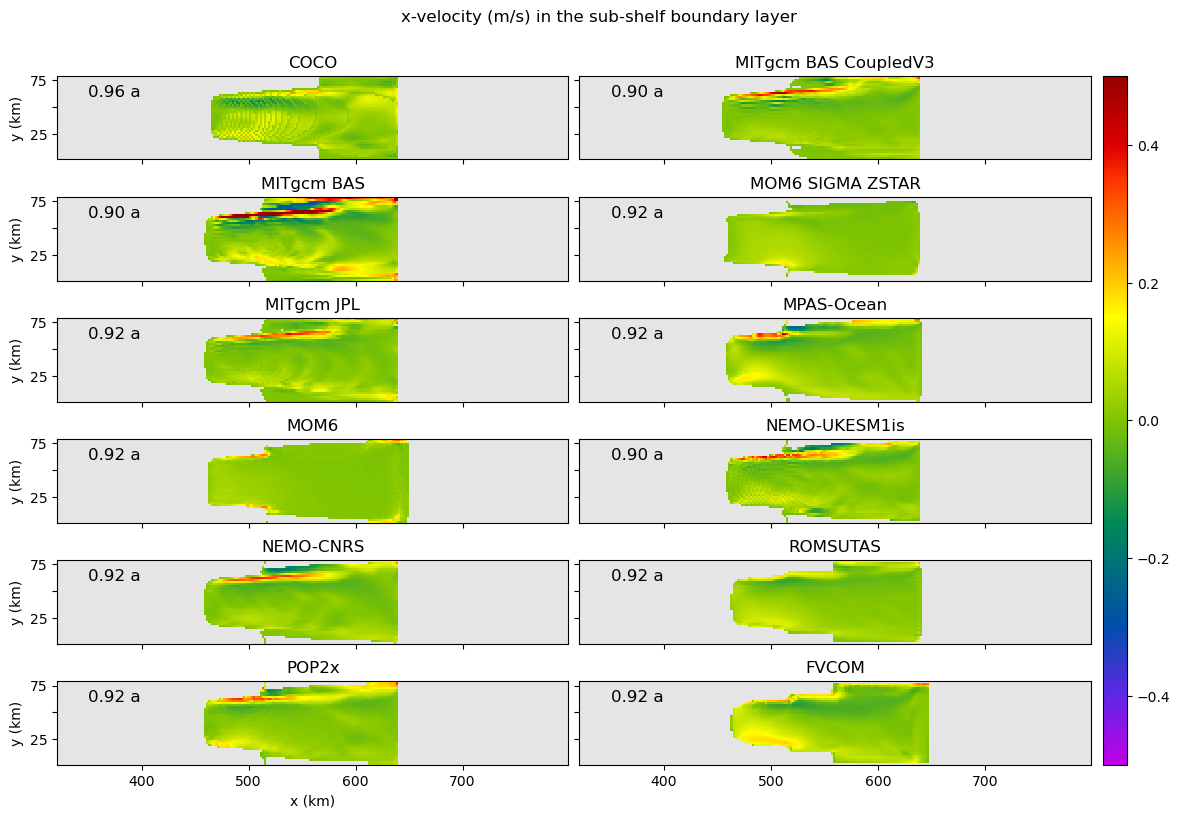

vBoundaryLayer


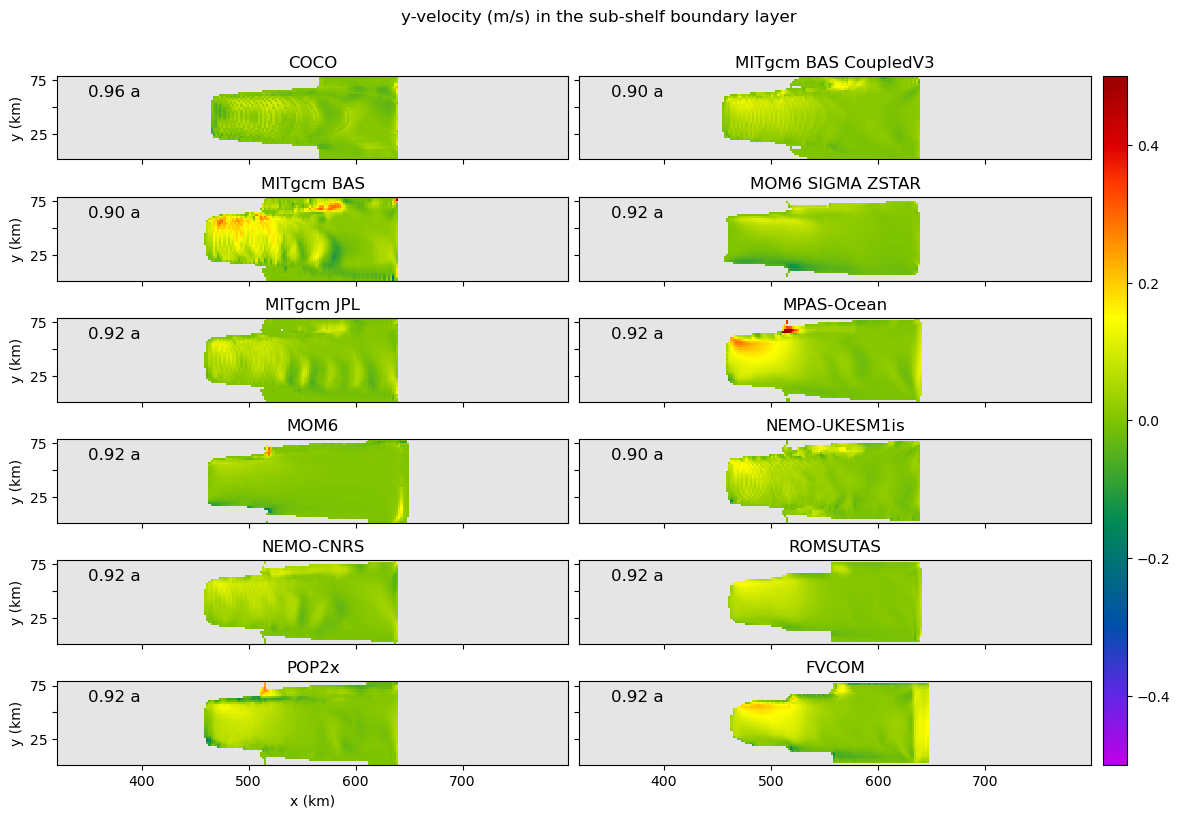

In [3]:
def plotOcean(fileNames,localTimeIndex):#, outFolder, movieFolder):
    baseName = os.path.basename(basedrive +fileNames[0])
    experiment = baseName.split('_')[0]
    modelNames = []
    for fileIndex in range(len(fileNames)):
        fileName = fileNames[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        modelNames.append(modelName)


    def plot(ax, var, label, scale, lower, upper, extent, localTimeIndex, axes):


        #ax.set_adjustable('box-forced')

        # aspect ratio
        if(axes == 'xy'):
            # pixels are 1:1
            aspectRatio = None
        else:
            # stretch the axes to fill the plot area
            aspectRatio = 'auto'

        field = var[localTimeIndex,:,:]

        missingValue = 9.9692099683868690e36
        if(np.ma.amax(field) == missingValue):
            # the array didnt' get masked properly, so do it manually
            field = np.ma.masked_array(field, mask=(field == missingValue), dtype=float)
        else:
            # convert from float32 to float64 to avoid overflow/underflow problems
            if hasattr(field, 'mask'):
                field = np.ma.masked_array(field, mask=field.mask, dtype=float)
            else:
                field = np.array(field, dtype=float)

        field *= scale

        # plot the data as an image
        im = ax.imshow(field, extent=extent, cmap=cmap, vmin=lower, vmax=upper,
                   aspect=aspectRatio, interpolation='nearest')
    

        if(axes == 'xy'):
            # y axis will be upside down in imshow, which we don't want for xy
            ax.invert_yaxis()
            ax.text(350., 60., label, fontsize=12)
        else:
            # upside-down y axis is okay
            ax.text(350., -80., label, fontsize=12)

        return im

    def plotFrame(varName, timeIndex):
    # the file name is the variable followed by the zero-padded time intex
    #imageFileName = '%s/%s_%04i.png'%(outFolder, varName, timeIndex)
    #if(os.path.exists(imageFileName)):
      # the image exists so we're going to save time and not replot it
      #return
        ncFile = Dataset(basedrive +fileNames[0],'r')
    # get the variable from the netCDF file
        try:
            var = ncFile.variables[varName]
        except KeyError:
            return

        axes = '%s%s'%(var.dimensions[2][1],var.dimensions[1][1])
        ncFile.close()

        if(axes == 'xy'):
          columnCount = min(2,len(fileNames))
          xLabel = 'x (km)'
          yLabel = 'y (km)'
          rowScale = 1.2
        elif(axes == 'xz'):
          columnCount = min(3,len(fileNames))
          rowScale = 2.0
          xLabel = 'x (km)'
          yLabel = 'z (m)'
        else:
          columnCount = min(3,len(fileNames))
          rowScale = 2.0
          xLabel = 'y (km)'
          yLabel = 'z (m)'

        rowCount = int(np.floor((len(fileNames)+columnCount-1)/columnCount))
        fileIndices = np.reshape(np.arange(rowCount*columnCount), (rowCount,columnCount))[::-1,:].ravel()
    
        fig, axarray = plt.subplots(rowCount, columnCount, sharex='col', sharey='row',
                                   figsize=[12, 0.5+rowScale*(rowCount+0.5)], dpi=100, facecolor='w')
    
        if(rowCount == 1):
          axarray = axarray.reshape((rowCount, columnCount))
    
        lastImage = []
        for index in range(len(fileIndices)):
          fileIndex = fileIndices[index]
          row = int(np.floor(rowCount-1 - index/columnCount))
          col = np.mod(index, columnCount)
    
          if fileIndex >= len(fileNames):
            plt.delaxes(axarray[row,col])
            continue
    
          fileName = fileNames[fileIndex]
          # get the filename without the path
    
          # open the netCDF file with the ISOMIP+ or MISOMIP1 ocean data
          ncFile = Dataset(basedrive +fileName,'r')
    
          # convert x and y to km
          x = 1e-3*ncFile.variables['x'][:]
          y = 1e-3*ncFile.variables['y'][:]
          # leave z in m
          z = ncFile.variables['z'][:]
          #localTimeIndex = min(timeIndex,len(ncFile.dimensions['nTime'])-1)
          timeVar = ncFile.variables['time']
          time = timeVar[localTimeIndex]
          year = time/sPerYr


          # the extents of the different plots for use in imshow
          if axes == 'xy':
            # the y extent is max then min because the y axis then gets flipped
            # (imshow is weird that way)
            extent = [np.amin(x),np.amax(x),np.amax(y),np.amin(y)]
          else:
            # we want the z-axis to be flipped so min and max are as one would expect
            if(z[0] > z[-1]):
              # we want the z-axis to be flipped so min and max are as one would expect
              if axes == 'xz':
                extent = [np.amin(x),np.amax(x),np.amin(z),np.amax(z)]
              else:
                extent = [np.amin(y),np.amax(y),np.amin(z),np.amax(z)]
            else:
              print("Error in z order in %s"%fileName)
              sys.exit(1)
    
          (lower, upper) = limits[varName]
          if varName in scales:
            scale = scales[varName]
          else:
            scale = 1.0
    
          #if ((varName in ['barotropicStreamfunction', 'halineDriving'])
          #    and (modelNames[fileIndex] == 'NEMO-CNRS')):
          #  scale *= -1




          ax = axarray[row, col]
          im = plot(ax, ncFile.variables[varName], '%.2f a'%year, scale, lower, upper,
                    extent, localTimeIndex, axes)
    
          if row == rowCount-1:
            ax.set_xlabel(xLabel)
    
          if col == columnCount-1:
            lastImage.append(im)
    
          if col == 0:
            ax.set_ylabel(yLabel)
            for label in ax.yaxis.get_ticklabels()[0::2]:
              label.set_visible(False)
    
          ax.set_title(modelNames[fileIndex])
          plt.tight_layout()
    
          ncFile.close()
    
        fig.subplots_adjust(right=0.91)
        if rowCount == 1:
          fig.subplots_adjust(top=0.85)
        else:
          fig.subplots_adjust(top=0.9)
        pos0 = axarray[0,-1].get_position()
        pos1 = axarray[-1,-1].get_position()
        top = pos0.y0 + pos0.height
        height = top - pos1.y0
        cbar_ax = fig.add_axes([0.92, pos1.y0, 0.02, height])
        cbar = fig.colorbar(lastImage[row], cax=cbar_ax)
        if rowCount == 1:
          for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
            label.set_visible(False)
    
        plt.suptitle(titles[varName])
    
        plt.draw()
        plt.show()
        #plt.savefig(imageFileName)
    
        #plt.close()
    
    

    def makeFerretColormap():
        red = np.array([[0,0.6],
                           [0.15,1],
                           [0.35,1],
                           [0.65,0],
                           [0.8,0],
                           [1,0.75]])
    
        green = np.array([[0,0],
                             [0.1,0],
                             [0.35,1],
                             [1,0]])
    
    
        blue = np.array([[0,0],
                           [0.5,0],
                           [0.9,0.9],
                           [1,0.9]])
    
        # light gray for use as an "invalid" background value wherever
        # data has been masked out in the NetCDF file
        backgroundColor = (0.9,0.9,0.9)
    
        colorCount = 21
        ferretColorList = np.ones((colorCount,4),float)
        ferretColorList[:,0] = np.interp(np.linspace(0,1,colorCount),red[:,0],red[:,1])
        ferretColorList[:,1] = np.interp(np.linspace(0,1,colorCount),green[:,0],green[:,1])
        ferretColorList[:,2] = np.interp(np.linspace(0,1,colorCount),blue[:,0],blue[:,1])
        ferretColorList = ferretColorList[::-1,:]
    
        cmap = colors.LinearSegmentedColormap.from_list('ferret',ferretColorList,N=255)
        cmap = plt.get_cmap(cmap)
        cmap.set_bad(backgroundColor)
        return cmap
      
    #modelNames = []
    first = True
    newNames = []
    for fileIndex in range(len(fileNames)):
        fileName = fileNames[fileIndex]
        if not os.path.exists(fileName):
          continue
        ncFile = Dataset(basedrive +basedrive +fileName,'r')
        if first:
            nTime = len(ncFile.dimensions['nTime'])
            first = False
        else:
            nTime = max(nTime, len(ncFile.dimensions['nTime']))
        newNames.append(fileName)
    
        baseName = os.path.basename(basedrive +fileName)
        # pull out the first part of the file name as the experiment name,
        # following the ISOMIP+ and MISOMIP1 filenaming requirements
        experiment = baseName.split('_')[0]
        prefix = baseName[:-3]
        #modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        #modelNames.append(modelName)
    
        # make sure this is a valid experiment (i.e. that the file has been
        # named correctly)
        if(experiment not in ['Ocean0','Ocean1','Ocean2','Ocean3','Ocean4',
                              'IceOcean1','IceOcean2']):
          print("Unknown experiment", experiment)
          exit(1)
    
        #outFolder = experiment
    #indices = np.argsort(modelNames)
    
      #fileNames = [newNames[i] for i in indices]
    #modelNames = [modelNames[i] for i in indices]
    #print(modelNames)
      #print(nTime)
      #try:
      #  os.mkdir(outFolder)
      #except:
      #  pass
    
    sPerYr = 365.*24.*60.*60.
    
      # a rainbow colormap based on the default map in the application ferret
    cmap = makeFerretColormap()
    
      # set the limits for the colorbars for each field, which are different
      # in some cases between the "colder" experiments (Ocean2 and Ocean4) and
      # "warmer" experiments (all the rest)
      # NOTE: Users should feel free to modify these limits to suit their needs.
    limits = {}
    if(experiment in ['Ocean0', 'Ocean1', 'Ocean3', 'IceOcean1', 'IceOcean2']):
        TLimits = [-2.5,1.1]
        SLimits = [33.6,34.8]
        limits['meltRate'] = [-100.,100.]
        limits['thermalDriving'] = [-1., 1.]
        limits['halineDriving'] = [-10., 10.]
        limits['frictionVelocity'] = [0, 0.02]
        limits['barotropicStreamfunction'] = [-0.3, 0.3]
        limits['overturningStreamfunction'] = [-0.2, 0.2]
    else:
        TLimits = [-2.5,-1.8]
        SLimits = [33.6,34.8]
        limits['meltRate'] = [-5.,5.]
        limits['thermalDriving'] = [-0.2, 0.2]
        limits['halineDriving'] = [-2.0, 2.0]
        limits['frictionVelocity'] = [0, 0.005]
        limits['barotropicStreamfunction'] = [-0.05, 0.05]
        limits['overturningStreamfunction'] = [-0.01,0.01]
    
    vLimits = [-0.5, 0.5]
    limits['uBoundaryLayer'] = vLimits
    limits['vBoundaryLayer'] = vLimits
    limits['bottomTemperature'] = TLimits
    limits['bottomSalinity'] = SLimits
    limits['temperatureXZ'] = TLimits
    limits['salinityXZ'] = SLimits
    limits['temperatureYZ'] = TLimits
    limits['salinityYZ'] = SLimits
    
    scales = {}
    scales['meltRate'] = sPerYr
    scales['barotropicStreamfunction'] = 1e-6
    scales['overturningStreamfunction'] = 1e-6
    
    titles = {}
    titles['meltRate'] = 'melt rate (m/a water equiv.)'
    titles['thermalDriving'] = 'thermal driving (C)'
    titles['halineDriving'] = 'haline driving (PSU)'
    titles['frictionVelocity'] = 'friction velocity (m/s)'
    titles['bottomTemperature'] = 'sea-floor temperature (C)'
    titles['bottomSalinity'] = 'sea-floor salinity (PSU)'
    titles['uBoundaryLayer'] = 'x-velocity (m/s) in the sub-shelf boundary layer'
    titles['vBoundaryLayer'] = 'y-velocity (m/s) in the sub-shelf boundary layer'
    titles['barotropicStreamfunction'] = 'barotropic streamfunction (Sv)'
    titles['overturningStreamfunction'] = 'overturning streamfunction (Sv)'
    titles['temperatureXZ'] = 'temperature (C) sliced through y=40 km'
    titles['salinityXZ'] = 'salinity (PSU) sliced through y=40 km'
    titles['temperatureYZ'] = 'temperature (C) sliced through x=540 km'
    titles['salinityYZ'] = 'salinity (PSU) sliced through x=540 km'
    
    
    
    varNames = list(limits.keys())
    varNames.sort()
      # put melt rate and temperatureXZ, etc. first because these are used most
    for varName in ['frictionVelocity', 'thermalDriving', 'meltRate', 'temperatureXZ']:
          varNames.remove(varName)
          varNames.insert(0,varName)
    
      # make plots for all the fields
    for varName in varNames:
        print(varName)
        #widgets = [varName, Percentage(), ' ', Bar(), ' ', ETA()]
        #time_bar = ProgressBar(widgets=widgets, maxval=nTime).start()
        #for timeIndex in range(nTime):
        plotFrame(varName,localTimeIndex)
          #time_bar.update(timeIndex+1)
        plt.show()
        #time_bar.finish()
    
        # for ext in ['mp4','avi']:
        #   args = ['avconv', '-y', '-r', '30', '-i', '%s/%s_%%04d.png'%(outFolder, varName),
        #           '-b:v', '32000k', '-r', '30', '%s/%s.%s'%(movieFolder, varName, ext)]
        #   subprocess.check_call(args)
    
    # if __name__ == "__main__":
    #   # we could add some optional command-line argument here but so far none...
    #   parser = OptionParser()
    #   options, args = parser.parse_args()
    
    #   if(len(args) < 2):
    #     print "usage: plotComparisonFrames.py <out_dir> <in_file1.nc> [<in_file2.nc> ...]"
    #     exit(1)
    
    #   # arguments are the COM file name and the directory for images
    #   outFolder = args[0]
    #   movieFolder = args[1]
    #   fileNames = args[2:]

fileNames = Ocean0_COM
time = 11 #months
plotOcean(fileNames,time)